### Importing Necessary Packages

In [1]:
import numpy as np
import cv2
import pathlib
import PIL.Image as Image
import os
import pandas as pd
import seaborn as sns
from pathlib import Path
import splitfolders
from distutils.dir_util import copy_tree
from glob import glob
import shutil

import matplotlib.pylab as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet import ResNet101, preprocess_input

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [2]:
print(tf.__version__)

2.5.0


### Downloading Flowers Images Dataset

In [3]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)
# cache_dir indicates where to download data. I specified . which means current directory
# untar true will unzip it

### Copying Flowers dataset to its own ResNet50 folder

In [4]:
ResNet101 = 'ResNet101 Data'
if os.path.exists(ResNet101):
    shutil.rmtree(ResNet101)
Path(ResNet101).mkdir(parents=True, exist_ok=True)
flower_photos_folder_path = "datasets"
copy_tree(flower_photos_folder_path, ResNet101)

['ResNet101 Data\\flower_photos\\daisy\\100080576_f52e8ee070_n.jpg',
 'ResNet101 Data\\flower_photos\\daisy\\10140303196_b88d3d6cec.jpg',
 'ResNet101 Data\\flower_photos\\daisy\\10172379554_b296050f82_n.jpg',
 'ResNet101 Data\\flower_photos\\daisy\\10172567486_2748826a8b.jpg',
 'ResNet101 Data\\flower_photos\\daisy\\10172636503_21bededa75_n.jpg',
 'ResNet101 Data\\flower_photos\\daisy\\102841525_bd6628ae3c.jpg',
 'ResNet101 Data\\flower_photos\\daisy\\1031799732_e7f4008c03.jpg',
 'ResNet101 Data\\flower_photos\\daisy\\10391248763_1d16681106_n.jpg',
 'ResNet101 Data\\flower_photos\\daisy\\10437754174_22ec990b77_m.jpg',
 'ResNet101 Data\\flower_photos\\daisy\\10437770546_8bb6f7bdd3_m.jpg',
 'ResNet101 Data\\flower_photos\\daisy\\10437929963_bc13eebe0c.jpg',
 'ResNet101 Data\\flower_photos\\daisy\\10466290366_cc72e33532.jpg',
 'ResNet101 Data\\flower_photos\\daisy\\10466558316_a7198b87e2.jpg',
 'ResNet101 Data\\flower_photos\\daisy\\10555749515_13a12a026e.jpg',
 'ResNet101 Data\\flower_ph

### Splitting the dataset folders into train and test

In [5]:
input_dir = ResNet101 + '/flower_photos'
output_dir = ResNet101 + '/datasets'

splitfolders.ratio(input_dir, output = output_dir, seed = 1337, ratio = (0.6,0.2,0.2), group_prefix = None)

Copying files: 3670 files [00:23, 156.10 files/s]


### Using ResNet101 Transfer Learning Algorithm

##### Importing ResNet101 Library

In [6]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet101(include_top=False,
                   input_shape=(224,224,3),
                   classes=5,
                   weights='imagenet')




##### Keeping existing weights untrained

In [7]:
for layer in pretrained_model.layers:
        layer.trainable=False
        
resnet_model.add(pretrained_model)

##### Here's few things to note about the above snippet of code:

1. While importing the ResNet50 class, we mention include_top=False. This ensures that we can add our own custom input and output layers according to our data.

2. We mention the weights='imagenet'. This means that the Resnet50 model will use the weights it learnt while being trained on the imagenet data.

3. Finally, we mention layer.trainable= False in the pretrained model. This ensures that the model does not learn the weights again, saving us a lot of time and space complexity.

##### Flatenning for the fully connected layer

In [8]:
resnet_model.add(Flatten())


##### Training the final layer for prediction

In [9]:
resnet_model.add(Dense(1024, activation='relu'))
resnet_model.add(Dense(1024, activation='relu'))
resnet_model.add(Dense(5, activation='softmax'))

##### Creating ResNet101 Model

In [10]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101 (Functional)       (None, 7, 7, 2048)        42658176  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              102761472 
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 5125      
Total params: 146,474,373
Trainable params: 103,816,197
Non-trainable params: 42,658,176
_________________________________________________________________


### Arranging Data

In [11]:
train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [12]:
# Make sure you provide the same target size as initialied for the image size
train_path = output_dir + '/train'
val_path = output_dir + '/val'
test_path = output_dir + '/test'

training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                                 seed = 42)

val_set = train_datagen.flow_from_directory(val_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical',
                                            seed = 42)

test_set = train_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 1,
                                            class_mode = 'categorical',
                                            seed = 42)

Found 2199 images belonging to 5 classes.
Found 731 images belonging to 5 classes.
Found 740 images belonging to 5 classes.


### Compiling and Fitting Model

##### Compiling the model with loss function, optimizer type and metrics of classification

In [13]:
# tell the model what cost and optimization method to use
resnet_model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])


##### Fitting the model

In [14]:
# fit the model
# Run the cell. It will take some time to execute
history = resnet_model.fit_generator(  training_set,
  validation_data=val_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(val_set))

Epoch 1/10
69/69 [==============================] - 337s 5s/step - loss: 5.8357 - accuracy: 0.7535 - val_loss: 0.7862 - val_accuracy: 0.8345
Epoch 2/10
69/69 [==============================] - 322s 5s/step - loss: 0.2593 - accuracy: 0.9409 - val_loss: 0.8767 - val_accuracy: 0.8659
Epoch 3/10
69/69 [==============================] - 324s 5s/step - loss: 0.1465 - accuracy: 0.9732 - val_loss: 1.2511 - val_accuracy: 0.8536
Epoch 4/10
69/69 [==============================] - 276s 4s/step - loss: 0.1227 - accuracy: 0.9773 - val_loss: 1.3026 - val_accuracy: 0.8659
Epoch 5/10
69/69 [==============================] - 187s 3s/step - loss: 0.2283 - accuracy: 0.9745 - val_loss: 1.5948 - val_accuracy: 0.8413
Epoch 6/10
69/69 [==============================] - 186s 3s/step - loss: 0.2909 - accuracy: 0.9709 - val_loss: 2.4121 - val_accuracy: 0.8536
Epoch 7/10
69/69 [==============================] - 185s 3s/step - loss: 0.4464 - accuracy: 0.9700 - val_loss: 2.3742 - val_accuracy: 0.8618
Epoch 8/10
69

##### Plot for Loss

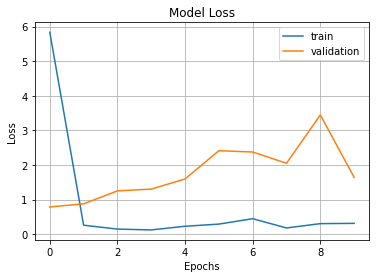

In [15]:
# plot the loss
fig1 = plt.gcf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()



##### Plot the accuracy

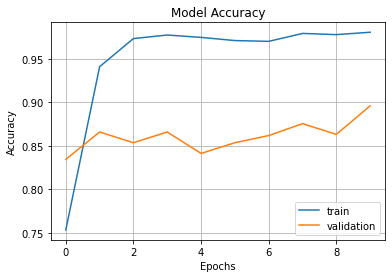

In [16]:
# plot the accuracy
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

##### Saving the model

In [17]:
resnet_model.save('model_ResNet101.h5')